- tenure
- balance
- credit score
- Estimated Salary
- Age

balance against age

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import shap
import warnings
warnings.filterwarnings('ignore')

## Data Setup (Binning and Grouping)

In [22]:
churn = pd.read_csv("Churn_Modelling.csv")
churn = churn.dropna().drop_duplicates().drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

churn = churn[['Tenure', 'Balance', 'CreditScore', 'EstimatedSalary', 'Age', 'Exited']]

In [23]:
churn.describe()

,Tenure,Balance,CreditScore,EstimatedSalary,Age,Exited
count,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000
mean,5.013305,76476.263216,650.503301,100106.701248,38.921071,0.203782
std,2.892353,62397.118820,96.624668,57513.314398,10.488421,0.402829
min,0.000000,0.000000,350.000000,11.580000,18.000000,0.000000
25%,3.000000,0.000000,584.000000,51002.110000,32.000000,0.000000
50%,5.000000,97173.290000,652.000000,100238.110000,37.000000,0.000000
75%,7.250000,127639.372500,717.250000,149400.107500,44.000000,0.000000
max,10.000000,250898.090000,850.000000,199992.480000,92.000000,1.000000


**Credit Score**: 
- 300-579 Poor
- 580–669 Fair
- 670–739 Good
- 740–799 Very Good
- 800–850 Excellent

**Tenure**
- < 1 Short Term
- 1-5 Medium Term
- *>* 5 Long Term

**Age**
- 18 - 30
- 31 - 35
- 36 - 40
- 41 - 50
- *>*= 51

**Balance**
- 0 Zero Balance
- 1-50K
- 50K-100K
- 100K - 150K
- 150K - 200K
- 200K+

**Salary**
- 0 - 50k
- 50k - 100k
- 100k - 150k
- 150k - 200k



In [25]:
## Tenure
# <1 => Short Term, 1-5 => Medium Term, >5 => Long Term
# We'll assume Tenure is an integer from 0 to 10. 
churn["Tenure_bin"] = pd.cut(
    churn["Tenure"], 
    bins=[-1, 1, 5, 11],       # Right boundary is exclusive by default if right=False
    labels=["Short", "Medium", "Long"],
    right=False
)

## Age
# 18-30, 31-35, 36-40, 41-50, >51
churn["Age_bin"] = pd.cut(
    churn["Age"],
    bins=[17, 31, 36, 41, 51, 120],  # 120 as an upper bound to cover all ages
    labels=["18-30", "31-35", "36-40", "41-50", "51+"],
    right=False
)

## Balance
# 0 => Zero Balance, 1-50K, 50K-100K, 100K-150K, 150K-200K, 200K+
churn["Balance_bin"] = pd.cut(
    churn["Balance"],
    bins=[-1, 1, 50000, 100000, 150000, 200000, float("inf")],
    labels=["Zero", "1-50K", "50K-100K", "100K-150K", "150K-200K", "200K+"],
    right=False
)

## Credit Score
# 300-579 => Poor, 580-669 => Fair, 670-739 => Good, 740-799 => Very Good, 800-850 => Excellent
churn["CreditScore_bin"] = pd.cut(
    churn["CreditScore"],
    bins=[299, 580, 670, 740, 800, 850],
    labels=["Poor", "Fair", "Good", "Very Good", "Excellent"],
    right=False
)

## EstimatedSalary
# 0-50k, 50k-100k, 100k-150k, 150k-200k, 200k+
churn["EstimatedSalary_bin"] = pd.cut(
    churn["EstimatedSalary"],
    bins=[0, 50000, 100000, 150000, 200000, float("inf")],
    labels=["0-50k", "50k-100k", "100k-150k", "150k-200k", "200k+"],
    right=False
)

In [26]:
churn = churn[['Exited',
       'Tenure_bin', 'Age_bin', 'Balance_bin', 'CreditScore_bin',
       'EstimatedSalary_bin']]

In [27]:
churn.head()

,Exited,Tenure_bin,Age_bin,Balance_bin,CreditScore_bin,EstimatedSalary_bin
0,1,Medium,41-50,Zero,Fair,100k-150k
1,0,Medium,41-50,50K-100K,Fair,100k-150k
2,1,Long,41-50,150K-200K,Poor,100k-150k
3,0,Medium,36-40,Zero,Good,50k-100k
5,1,Long,41-50,100K-150K,Fair,100k-150k


## EDA

### Age

/var/folders/h9/53n9lw0j4gs52q5wd5c028g80000gn/T/ipykernel_73063/560936200.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_churn = churn.groupby('Age_bin')['Exited'].agg(['count', 'sum'])


         count  sum  Churn_Rate
Age_bin                        
18-30     1967  148    0.075241
31-35     2185  199    0.091076
36-40     2266  339    0.149603
41-50     2317  788    0.340095
51+       1261  563    0.446471


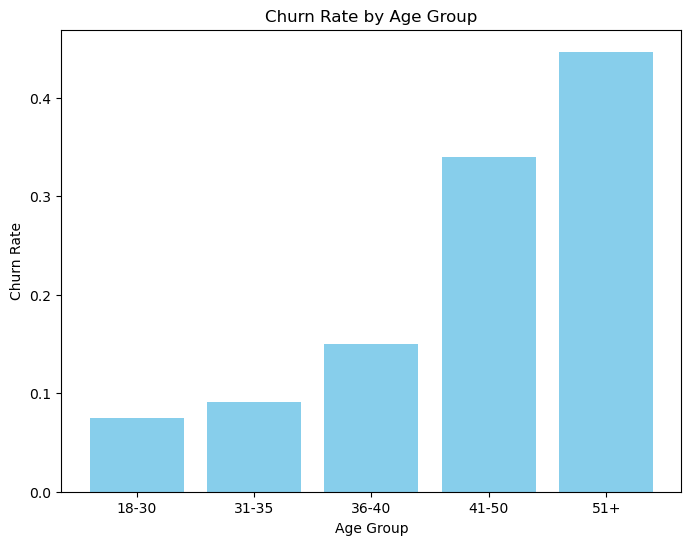

In [28]:
# Calculate churn rate per age bin
age_churn = churn.groupby('Age_bin')['Exited'].agg(['count', 'sum'])
age_churn['Churn_Rate'] = age_churn['sum'] / age_churn['count']

print(age_churn)

# Plot churn rate by age group
plt.figure(figsize=(8, 6))
plt.bar(age_churn.index.astype(str), age_churn['Churn_Rate'], color='skyblue')
plt.xlabel("Age Group")
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Age Group")
plt.show()

### Tenure

            count   sum  Churn_Rate
Tenure_bin                         
Short         413    95    0.230024
Medium       4078   849    0.208190
Long         5505  1093    0.198547


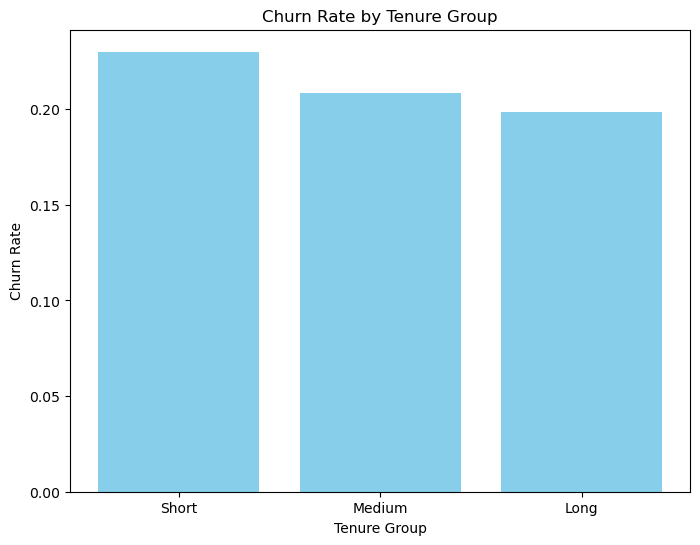

In [31]:
# Calculate churn rate per tenure bin
tenure_churn = churn.groupby('Tenure_bin')['Exited'].agg(['count', 'sum'])
tenure_churn['Churn_Rate'] = tenure_churn['sum'] / tenure_churn['count']

print(tenure_churn)

# Plot churn rate by tenure group
plt.figure(figsize=(8, 6))
plt.bar(tenure_churn.index.astype(str), tenure_churn['Churn_Rate'], color='skyblue')
plt.xlabel("Tenure Group")
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Tenure Group")
plt.show()

### Balance

             count  sum  Churn_Rate
Balance_bin                        
Zero          3616  500    0.138274
1-50K           75   26    0.346667
50K-100K      1509  300    0.198807
100K-150K     3827  987    0.257904
150K-200K      935  205    0.219251
200K+           34   19    0.558824


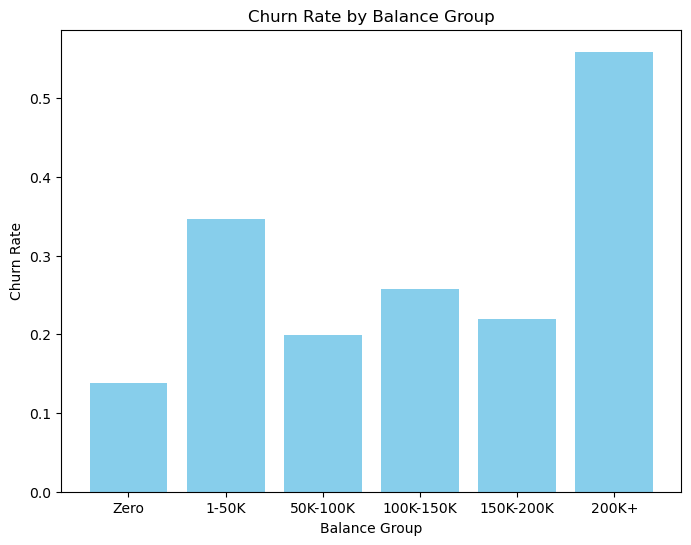

In [32]:
# Calculate churn rate per balance bin
balance_churn = churn.groupby('Balance_bin')['Exited'].agg(['count', 'sum'])
balance_churn['Churn_Rate'] = balance_churn['sum'] / balance_churn['count']

print(balance_churn)

# Plot churn rate by balance group
plt.figure(figsize=(8, 6))
plt.bar(balance_churn.index.astype(str), balance_churn['Churn_Rate'], color='skyblue')
plt.xlabel("Balance Group")
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Balance Group")
plt.show()

### Credit Score

                 count  sum  Churn_Rate
CreditScore_bin                        
Poor              2361  520    0.220246
Fair              3331  685    0.205644
Good              2427  452    0.186238
Very Good         1224  252    0.205882
Excellent          421   85    0.201900


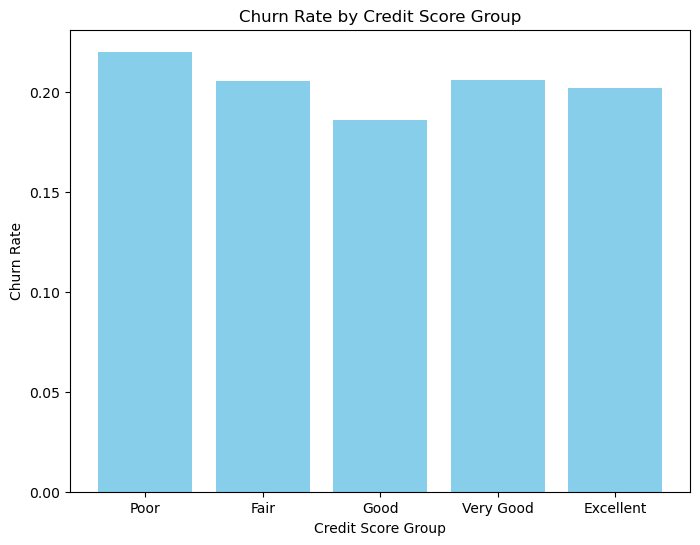

In [33]:
# Calculate churn rate per credit score bin
credit_churn = churn.groupby('CreditScore_bin')['Exited'].agg(['count', 'sum'])
credit_churn['Churn_Rate'] = credit_churn['sum'] / credit_churn['count']

print(credit_churn)

# Plot churn rate by credit score group
plt.figure(figsize=(8, 6))
plt.bar(credit_churn.index.astype(str), credit_churn['Churn_Rate'], color='skyblue')
plt.xlabel("Credit Score Group")
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Credit Score Group")
plt.show()

### Salary

                     count  sum  Churn_Rate
EstimatedSalary_bin                        
0-50k                 2452  489    0.199429
50k-100k              2534  504    0.198895
100k-150k             2555  517    0.202348
150k-200k             2455  527    0.214664
200k+                    0    0         NaN


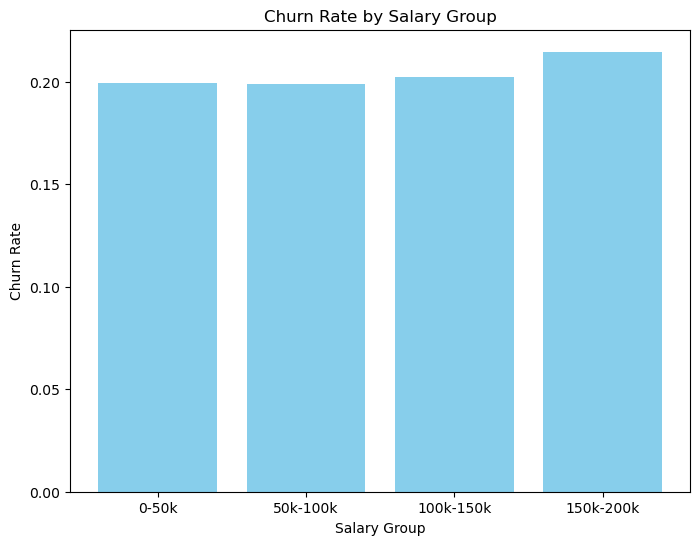

In [34]:
# Calculate churn rate per salary bin
salary_churn = churn.groupby('EstimatedSalary_bin')['Exited'].agg(['count', 'sum'])
salary_churn['Churn_Rate'] = salary_churn['sum'] / salary_churn['count']

print(salary_churn)

# Plot churn rate by salary group
plt.figure(figsize=(8, 6))
plt.bar(salary_churn.index.astype(str), salary_churn['Churn_Rate'], color='skyblue')
plt.xlabel("Salary Group")
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Salary Group")
plt.show()

# Random Forest Model

In [41]:
X = churn[["Tenure_bin", "Age_bin", "Balance_bin", "CreditScore_bin", "EstimatedSalary_bin"]]
y = churn["Exited"]

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

# Build a pipeline to One-Hot Encode the binned features and then fit a Random Forest
cat_features = X.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first"), cat_features)  
    ],
    remainder="drop"  
)

rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit the pipeline on the training set
rf_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_pipeline.predict(X_test)
y_pred_proba = rf_pipeline.predict_proba(X_test)[:, 1]  # Probability of the positive class

# Evaluate performance
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {auc_score:.4f}")

=== Confusion Matrix ===
[[1489  103]
 [ 336   72]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.82      0.94      0.87      1592
           1       0.41      0.18      0.25       408

    accuracy                           0.78      2000
   macro avg       0.61      0.56      0.56      2000
weighted avg       0.73      0.78      0.74      2000

ROC AUC: 0.6836


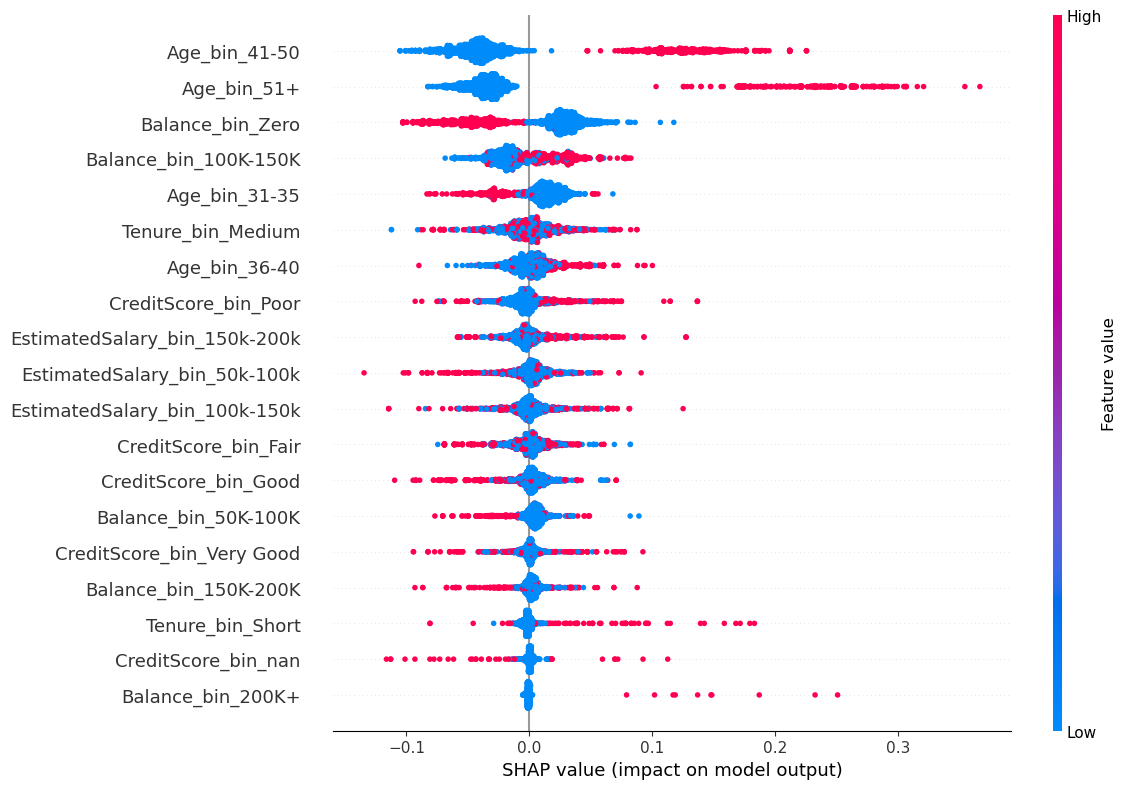

In [69]:
# Transform test data using the pipeline's preprocessor
X_test_transformed = rf_pipeline.named_steps['preprocessor'].transform(X_test)
X_test_transformed = X_test_transformed.toarray()
X_test_transformed = X_test_transformed.astype(np.float32)

# Get feature names from your one-hot encoder
ohe = rf_pipeline.named_steps['preprocessor'].named_transformers_['ohe']
feature_names = ohe.get_feature_names_out(X_test.columns)

# Create a SHAP TreeExplainer using the fitted Random Forest model
explainer = shap.TreeExplainer(rf_pipeline.named_steps['rf'])

# Compute SHAP values for the transformed test set
shap_values = explainer.shap_values(X_test_transformed)

# For binary classification, shap_values is a list with two arrays (one for each class)
# We'll use the SHAP values for the positive class (churn = 1)
shap_values_pos = shap_values[:, :, 1]

# Create a summary plot to visualize feature importance
shap.summary_plot(shap_values_pos, X_test_transformed, feature_names=feature_names, plot_size=(12, 8))